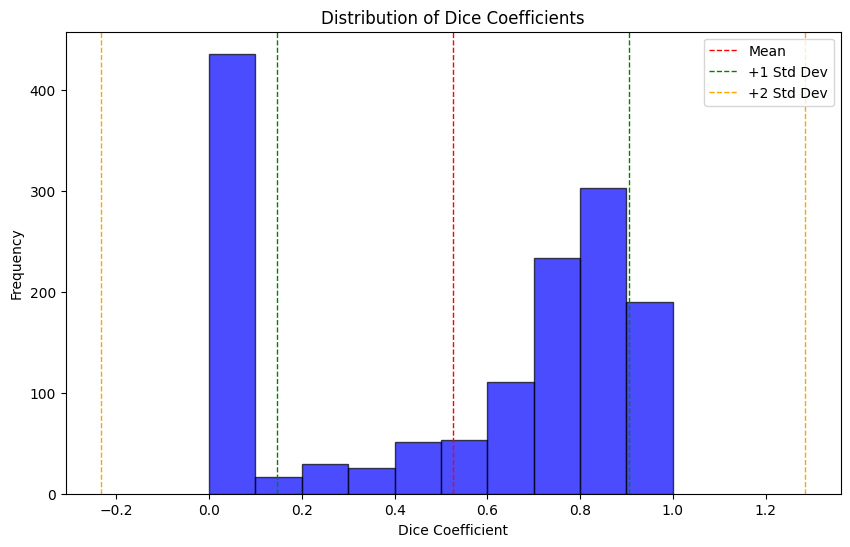

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Path to the JSON file
file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/Dataset020_AutoPET2024_Regions_results.json"

# Reading the JSON file
with open(file_path, "r") as file:
    data = json.load(file)

# Extracting dice values from the JSON data
dice_values = [entry["dice"] for entry in data.values()]

# Calculating mean and standard deviations
mean_dice = np.mean(dice_values)
std_dice = np.std(dice_values)

# Creating the plot
plt.figure(figsize=(10, 6))
plt.hist(dice_values, bins=10, alpha=0.7, color="blue", edgecolor="black")

# Adding mean, 1st std, and 2nd std lines
plt.axvline(mean_dice, color="red", linestyle="dashed", linewidth=1, label="Mean")
plt.axvline(
    mean_dice + std_dice,
    color="green",
    linestyle="dashed",
    linewidth=1,
    label="+1 Std Dev",
)
plt.axvline(mean_dice - std_dice, color="green", linestyle="dashed", linewidth=1)
plt.axvline(
    mean_dice + 2 * std_dice,
    color="orange",
    linestyle="dashed",
    linewidth=1,
    label="+2 Std Dev",
)
plt.axvline(mean_dice - 2 * std_dice, color="orange", linestyle="dashed", linewidth=1)

# Adding labels and title
plt.xlabel("Dice Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of Dice Coefficients")
plt.legend()

# Display the plot
plt.show()

(array([0, 1]), array([397, 121]))


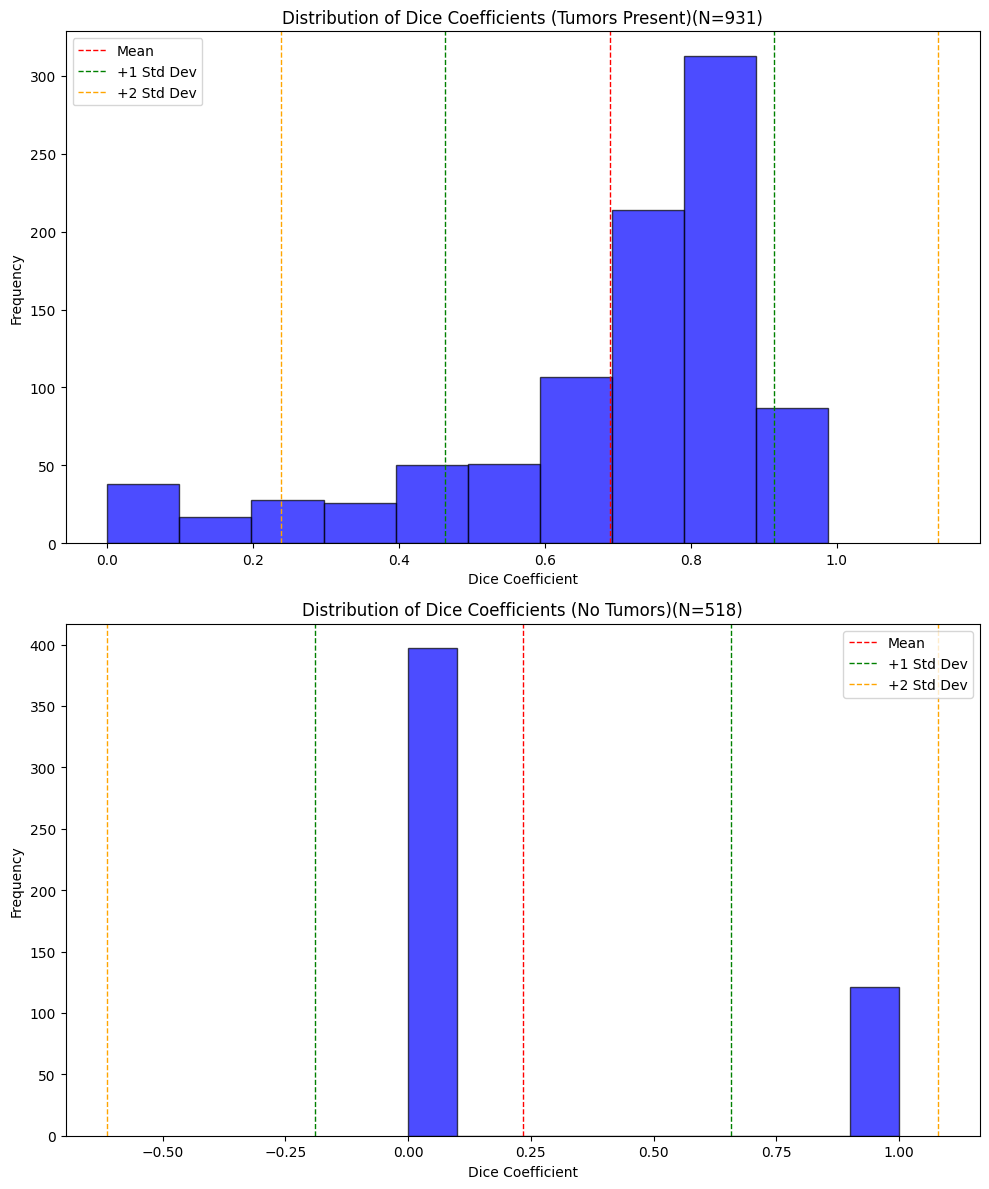

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths to the files
json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/Dataset020_AutoPET2024_Regions_results.json"
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"

# Reading the JSON file
with open(json_file_path, "r") as file:
    json_data = json.load(file)

# Reading the CSV file
csv_data = pd.read_csv(csv_file_path)

# Extracting dice values and matching with the CSV data
dice_values_with_tumors = []
dice_values_without_tumors = []

for entry in json_data.values():
    subject_name = entry["Name"]
    dice_value = entry["dice"]

    match = csv_data[csv_data["Subject"] == subject_name]
    if not match.empty:
        if match["Tumors_Present"].values[0] == 1:
            dice_values_with_tumors.append(dice_value)
        else:
            dice_values_without_tumors.append(dice_value)


# Function to plot distribution
def plot_distribution(dice_values, title, ax):
    mean_dice = np.mean(dice_values)
    std_dice = np.std(dice_values)

    ax.hist(dice_values, bins=10, alpha=0.7, color="blue", edgecolor="black")

    ax.axvline(mean_dice, color="red", linestyle="dashed", linewidth=1, label="Mean")
    ax.axvline(
        mean_dice + std_dice,
        color="green",
        linestyle="dashed",
        linewidth=1,
        label="+1 Std Dev",
    )
    ax.axvline(mean_dice - std_dice, color="green", linestyle="dashed", linewidth=1)
    ax.axvline(
        mean_dice + 2 * std_dice,
        color="orange",
        linestyle="dashed",
        linewidth=1,
        label="+2 Std Dev",
    )
    ax.axvline(
        mean_dice - 2 * std_dice, color="orange", linestyle="dashed", linewidth=1
    )

    ax.set_xlabel("Dice Coefficient")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    ax.legend()


# Creating the plots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

plot_distribution(
    dice_values_with_tumors,
    f"Distribution of Dice Coefficients (Tumors Present)(N={len(dice_values_with_tumors)})",
    axs[0],
)
plot_distribution(
    dice_values_without_tumors,
    f"Distribution of Dice Coefficients (No Tumors)(N={len(dice_values_without_tumors)})",
    axs[1],
)
print(np.unique(dice_values_without_tumors, return_counts=True))

# Display the plots
plt.tight_layout()
plt.show()

(array([0, 1]), array([402, 116]))


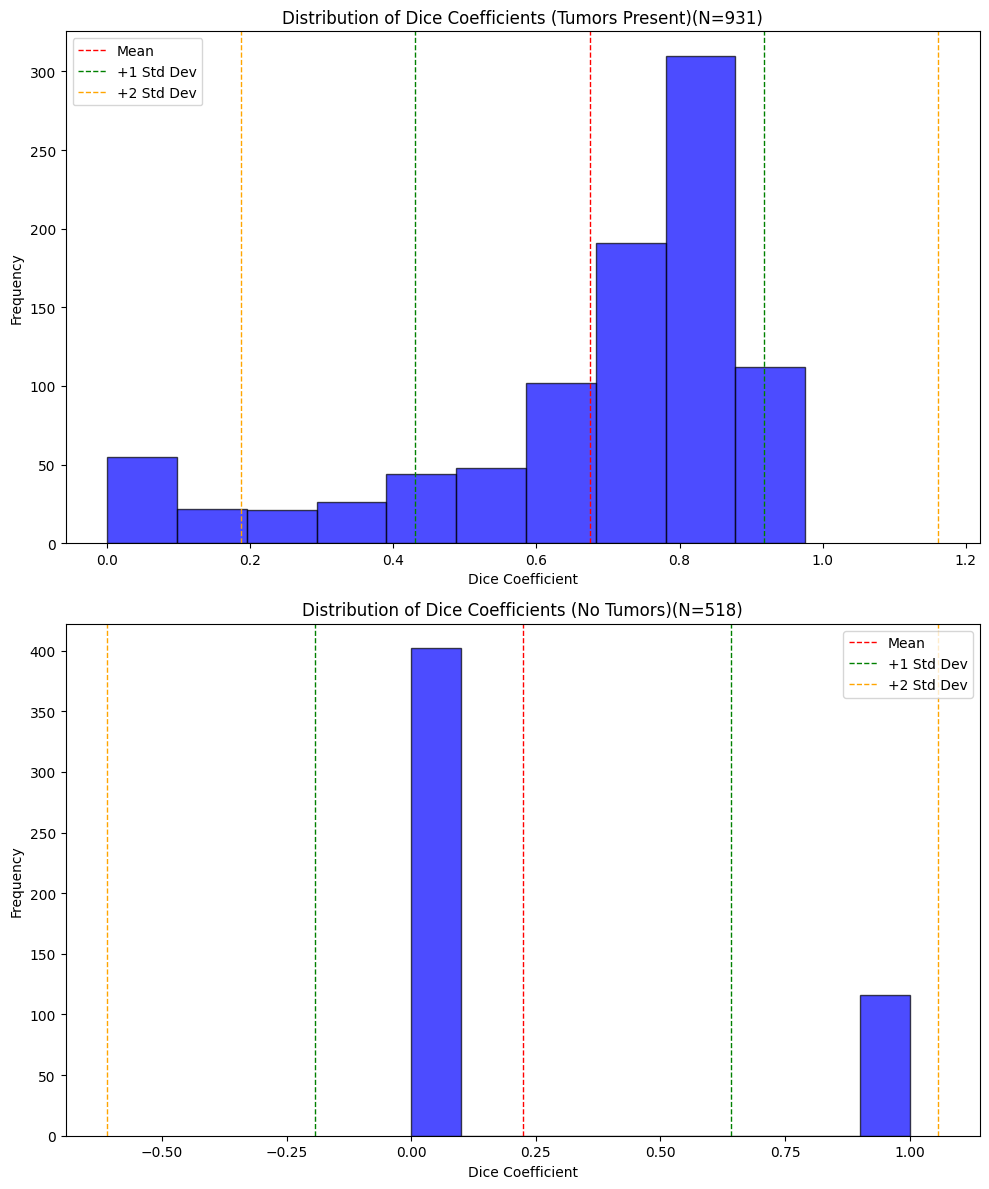

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths to the files
json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/Dataset019_AutoPET2024_results.json"
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"

# Reading the JSON file
with open(json_file_path, "r") as file:
    json_data = json.load(file)

# Reading the CSV file
csv_data = pd.read_csv(csv_file_path)

# Extracting dice values and matching with the CSV data
dice_values_with_tumors = []
dice_values_without_tumors = []

for entry in json_data.values():
    subject_name = entry["Name"]
    dice_value = entry["dice"]

    match = csv_data[csv_data["Subject"] == subject_name]
    if not match.empty:
        if match["Tumors_Present"].values[0] == 1:
            dice_values_with_tumors.append(dice_value)
        else:
            dice_values_without_tumors.append(dice_value)


# Function to plot distribution
def plot_distribution(dice_values, title, ax):
    mean_dice = np.mean(dice_values)
    std_dice = np.std(dice_values)

    ax.hist(dice_values, bins=10, alpha=0.7, color="blue", edgecolor="black")

    ax.axvline(mean_dice, color="red", linestyle="dashed", linewidth=1, label="Mean")
    ax.axvline(
        mean_dice + std_dice,
        color="green",
        linestyle="dashed",
        linewidth=1,
        label="+1 Std Dev",
    )
    ax.axvline(mean_dice - std_dice, color="green", linestyle="dashed", linewidth=1)
    ax.axvline(
        mean_dice + 2 * std_dice,
        color="orange",
        linestyle="dashed",
        linewidth=1,
        label="+2 Std Dev",
    )
    ax.axvline(
        mean_dice - 2 * std_dice, color="orange", linestyle="dashed", linewidth=1
    )

    ax.set_xlabel("Dice Coefficient")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    ax.legend()


# Creating the plots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

plot_distribution(
    dice_values_with_tumors,
    f"Distribution of Dice Coefficients (Tumors Present)(N={len(dice_values_with_tumors)})",
    axs[0],
)
plot_distribution(
    dice_values_without_tumors,
    f"Distribution of Dice Coefficients (No Tumors)(N={len(dice_values_without_tumors)})",
    axs[1],
)
print(np.unique(dice_values_without_tumors, return_counts=True))

# Display the plots
plt.tight_layout()
plt.show()

(array([0, 1]), array([276, 242]))


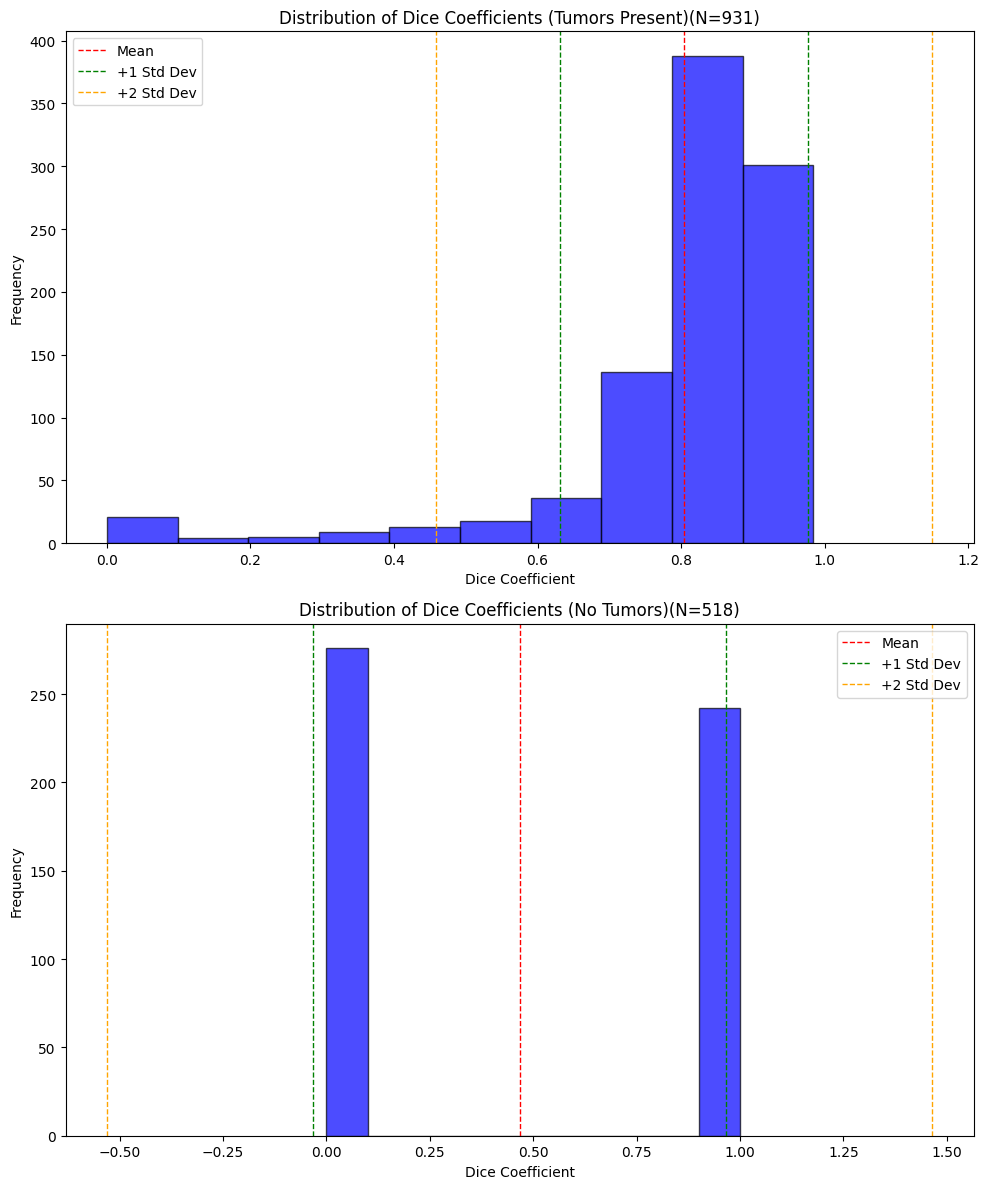

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths to the files
json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/Dataset019_AutoPET2024_res.json"
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"

# Reading the JSON file
with open(json_file_path, "r") as file:
    json_data = json.load(file)

# Reading the CSV file
csv_data = pd.read_csv(csv_file_path)

# Extracting dice values and matching with the CSV data
dice_values_with_tumors = []
dice_values_without_tumors = []

for entry in json_data.values():
    subject_name = entry["Name"]
    dice_value = entry["dice"]

    match = csv_data[csv_data["Subject"] == subject_name]
    if not match.empty:
        if match["Tumors_Present"].values[0] == 1:
            dice_values_with_tumors.append(dice_value)
        else:
            dice_values_without_tumors.append(dice_value)


# Function to plot distribution
def plot_distribution(dice_values, title, ax):
    mean_dice = np.mean(dice_values)
    std_dice = np.std(dice_values)

    ax.hist(dice_values, bins=10, alpha=0.7, color="blue", edgecolor="black")

    ax.axvline(mean_dice, color="red", linestyle="dashed", linewidth=1, label="Mean")
    ax.axvline(
        mean_dice + std_dice,
        color="green",
        linestyle="dashed",
        linewidth=1,
        label="+1 Std Dev",
    )
    ax.axvline(mean_dice - std_dice, color="green", linestyle="dashed", linewidth=1)
    ax.axvline(
        mean_dice + 2 * std_dice,
        color="orange",
        linestyle="dashed",
        linewidth=1,
        label="+2 Std Dev",
    )
    ax.axvline(
        mean_dice - 2 * std_dice, color="orange", linestyle="dashed", linewidth=1
    )

    ax.set_xlabel("Dice Coefficient")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    ax.legend()


# Creating the plots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

plot_distribution(
    dice_values_with_tumors,
    f"Distribution of Dice Coefficients (Tumors Present)(N={len(dice_values_with_tumors)})",
    axs[0],
)
plot_distribution(
    dice_values_without_tumors,
    f"Distribution of Dice Coefficients (No Tumors)(N={len(dice_values_without_tumors)})",
    axs[1],
)
print(np.unique(dice_values_without_tumors, return_counts=True))

# Display the plots
plt.tight_layout()
plt.show()